In [1]:
from google.colab import files
files.upload()  # upload your kaggle.json here

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# --- STEP 2: Download dataset from Kaggle ---
!kaggle datasets download -d noulam/tomato

# --- STEP 3: Unzip dataset ---
!unzip -q tomato.zip -d dataset/


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/noulam/tomato
License(s): copyright-authors
 97% 719M/743M [00:02<00:00, 266MB/s]
100% 743M/743M [00:04<00:00, 189MB/s]


In [2]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt

In [3]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    'dataset',
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=False
)

val_gen = datagen.flow_from_directory(
    'dataset',
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 36688 images belonging to 2 classes.
Found 9172 images belonging to 2 classes.


In [4]:
#Feature extraction

base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(128,128,3))
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

#Extract features
print("Extracting features for training set...")
features_train = feature_extractor.predict(train_gen, verbose=1)
labels_train = train_gen.classes

print("Extracting features for validation set...")
features_val = feature_extractor.predict(val_gen, verbose=1)
labels_val = val_gen.classes

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Extracting features for training set...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1147/1147 ━━━━━━━━━━━━━━━━━━━━ 65s 46ms/step
Extracting features for validation set...
287/287 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step


🧩 Using subset of 5000 samples for quick training...
🌲 Training Random Forest model...

🔹 Evaluating model ...

✅ Validation Accuracy: 50.00%

📊 Classification Report:
                                       precision    recall  f1-score   support

New Plant Diseases Dataset(Augmented)       0.50      0.52      0.51      4586
new plant diseases dataset(augmented)       0.50      0.48      0.49      4586

                             accuracy                           0.50      9172
                            macro avg       0.50      0.50      0.50      9172
                         weighted avg       0.50      0.50      0.50      9172



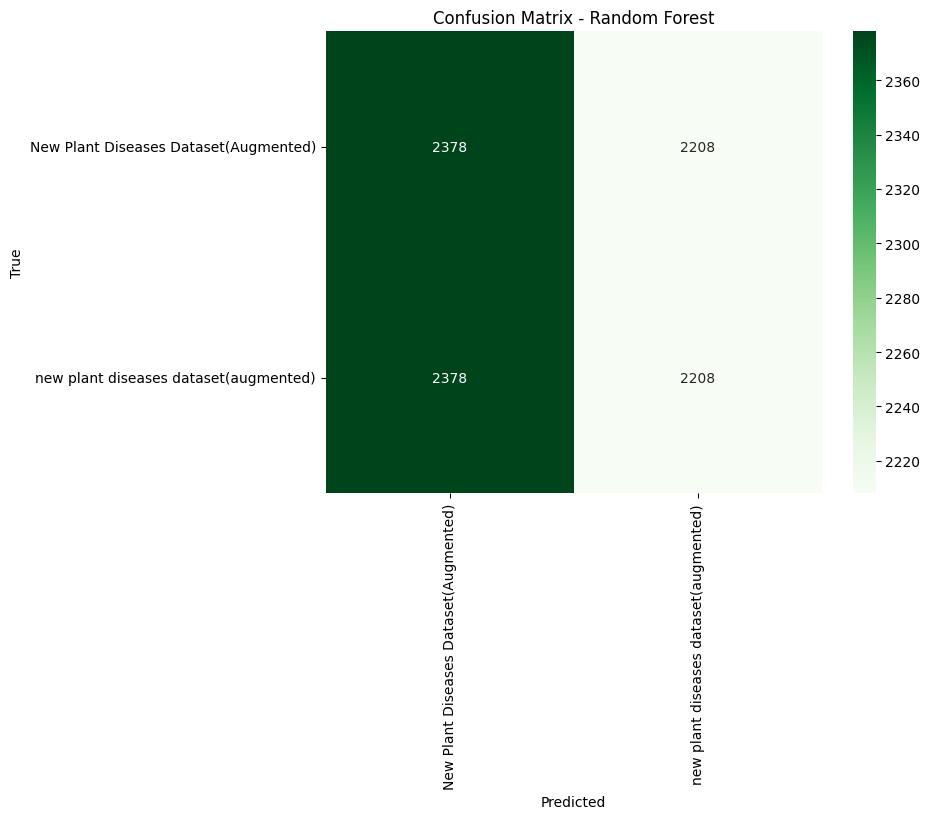

💾 Model saved as 'best_model_RF.pkl'


In [5]:
# 🌿 Step 8: Train & Evaluate Random Forest (Faster & More Accurate)
# ================================================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# --- Optional: Use subset if dataset is huge ---
sample = 5000  # use fewer if you want faster runs (e.g. 3000)
indices = random.sample(range(len(features_train)), sample)
features_train_sub = features_train[indices]
labels_train_sub = labels_train[indices]

print(f"🧩 Using subset of {sample} samples for quick training...")

# --- Train Random Forest ---
print("🌲 Training Random Forest model...")
rf_model = RandomForestClassifier(
    n_estimators=200,        # number of trees
    max_depth=None,          # let trees grow fully
    min_samples_split=2,
    n_jobs=-1,               # use all CPU cores
    random_state=42
)
rf_model.fit(features_train_sub, labels_train_sub)

# --- Evaluate ---
print("\n🔹 Evaluating model ...")
y_pred = rf_model.predict(features_val)
acc = accuracy_score(labels_val, y_pred)
print(f"\n✅ Validation Accuracy: {acc*100:.2f}%")

# --- Classification report ---
target_names = list(train_gen.class_indices.keys())
print("\n📊 Classification Report:")
print(classification_report(labels_val, y_pred, target_names=target_names))

# --- Confusion Matrix ---
cm = confusion_matrix(labels_val, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --- Save model ---
joblib.dump(rf_model, 'best_model_RF.pkl')
print("💾 Model saved as 'best_model_RF.pkl'")


In [6]:
# 🌿 Step 8: MobileNetV2 + RandomForest Classifier (Fast & Accurate)
# ================================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tqdm import tqdm

# --- Step 1: Load MobileNetV2 base (no top layer) ---
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
x = GlobalAveragePooling2D()(base_model.output)
model = Model(inputs=base_model.input, outputs=x)

print("✅ MobileNetV2 feature extractor loaded!")

# --- Step 2: Extract features for train and validation sets ---
def extract_features(generator):
    features = []
    labels = []
    for i in tqdm(range(len(generator))):
        x_batch, y_batch = generator[i]
        f = model.predict(x_batch, verbose=0)
        features.append(f)
        labels.append(y_batch)
    return np.concatenate(features), np.concatenate(labels)

print("🔹 Extracting features for training data...")
features_train, labels_train = extract_features(train_gen)

print("🔹 Extracting features for validation data...")
features_val, labels_val = extract_features(val_gen)

print("✅ Feature extraction complete!")
print("Train features shape:", features_train.shape)
print("Validation features shape:", features_val.shape)

# --- Step 3: Train Random Forest ---
print("\n🌲 Training Random Forest (100 trees)...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(features_train, labels_train)

# --- Step 4: Evaluate ---
print("\n🔹 Evaluating model ...")
y_pred = rf_model.predict(features_val)
acc = accuracy_score(labels_val, y_pred)
print(f"\n✅ Validation Accuracy: {acc*100:.2f}%")

# --- Classification Report ---
target_names = list(train_gen.class_indices.keys())
print("\n📊 Classification Report:")
print(classification_report(labels_val, y_pred, target_names=target_names))

# --- Confusion Matrix ---
cm = confusion_matrix(labels_val, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix - RandomForest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --- Step 5: Save the trained model ---
joblib.dump(rf_model, 'best_model_RF.pkl')
print("💾 Model saved as 'best_model_RF.pkl'")


✅ MobileNetV2 feature extractor loaded!
🔹 Extracting features for training data...


100%|██████████| 1147/1147 [02:14<00:00,  8.50it/s]


🔹 Extracting features for validation data...


100%|██████████| 287/287 [00:34<00:00,  8.34it/s]


✅ Feature extraction complete!
Train features shape: (36688, 1280)
Validation features shape: (9172, 1280)

🌲 Training Random Forest (100 trees)...

🔹 Evaluating model ...

✅ Validation Accuracy: 49.98%

📊 Classification Report:
                                       precision    recall  f1-score   support

New Plant Diseases Dataset(Augmented)       0.50      0.50      0.50      4586
new plant diseases dataset(augmented)       0.50      0.50      0.50      4586

                            micro avg       0.50      0.50      0.50      9172
                            macro avg       0.50      0.50      0.50      9172
                         weighted avg       0.50      0.50      0.50      9172
                          samples avg       0.50      0.50      0.50      9172



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ValueError: multilabel-indicator is not supported

In [7]:
import os
for folder in os.listdir('/content/train'):
    print(folder)


FileNotFoundError: [Errno 2] No such file or directory: '/content/train'

In [8]:
!rm -rf "/content/dataset/new plant diseases dataset(augmented)"


In [9]:
!mv "/content/dataset/New Plant Diseases Dataset(Augmented)" "/content/dataset/tomato_dataset"


In [10]:
!ls /content/dataset/tomato_dataset


train  valid


In [12]:
# 1️⃣ Clean up duplicates
!rm -rf "/content/dataset/new plant diseases dataset(augmented)"

# 2️⃣ Rename the remaining folder to something clean
!mv "/content/dataset/New Plant Diseases Dataset(Augmented)" "/content/dataset/tomato_dataset"

# 3️⃣ Check structure
!ls /content/dataset/tomato_dataset


mv: cannot stat '/content/dataset/New Plant Diseases Dataset(Augmented)': No such file or directory
train  valid


In [13]:
!ls /content/dataset/tomato_dataset/train


 Tomato___Bacterial_spot   Tomato___Septoria_leaf_spot
 Tomato___Early_blight	  'Tomato___Spider_mites Two-spotted_spider_mite'
 Tomato___healthy	   Tomato___Target_Spot
 Tomato___Late_blight	   Tomato___Tomato_mosaic_virus
 Tomato___Leaf_Mold	   Tomato___Tomato_Yellow_Leaf_Curl_Virus


In [14]:
train_dir = '/content/dataset/tomato_dataset/train'
val_dir   = '/content/dataset/tomato_dataset/valid'

train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse'
)

val_gen = datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse'
)


Found 18345 images belonging to 10 classes.
Found 4585 images belonging to 10 classes.


✅ MobileNetV2 feature extractor loaded!
🔹 Extracting features for training data...


100%|██████████| 574/574 [01:18<00:00,  7.28it/s]


🔹 Extracting features for validation data...


100%|██████████| 144/144 [00:15<00:00,  9.24it/s]


✅ Feature extraction complete!
Train features shape: (18345, 1280)
Validation features shape: (4585, 1280)

🌲 Training Random Forest (100 trees)...

🔹 Evaluating model ...

✅ Validation Accuracy: 82.68%

📊 Classification Report:
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.81      0.90      0.85       425
                        Tomato___Early_blight       0.78      0.68      0.73       480
                         Tomato___Late_blight       0.86      0.83      0.84       463
                           Tomato___Leaf_Mold       0.80      0.80      0.80       470
                  Tomato___Septoria_leaf_spot       0.77      0.75      0.76       436
Tomato___Spider_mites Two-spotted_spider_mite       0.77      0.83      0.80       435
                         Tomato___Target_Spot       0.73      0.69      0.71       457
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.93      0.92      0.

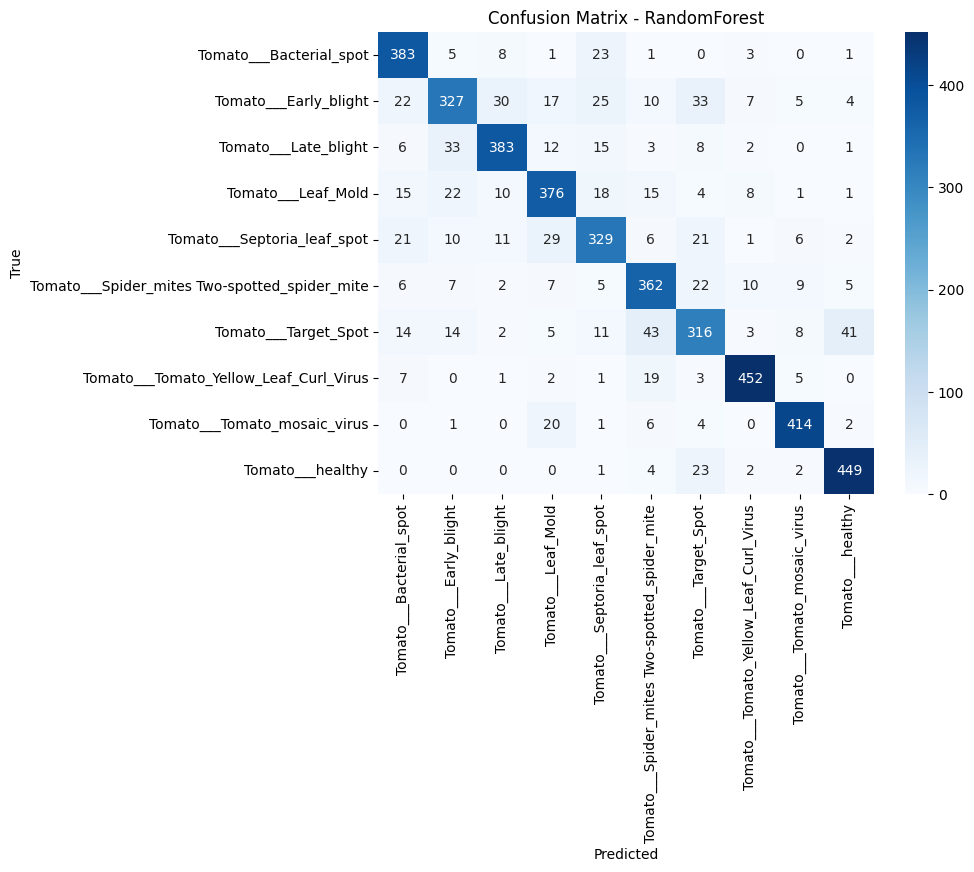

💾 Model saved as 'best_model_RF.pkl'


In [17]:
# 🌿 Step 8: MobileNetV2 + RandomForest Classifier (Fast & Accurate)
# ================================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tqdm import tqdm

# --- Step 1: Load MobileNetV2 base (no top layer) ---
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
x = GlobalAveragePooling2D()(base_model.output)
model = Model(inputs=base_model.input, outputs=x)

print("✅ MobileNetV2 feature extractor loaded!")

# --- Step 2: Extract features for train and validation sets ---
def extract_features(generator):
    features = []
    labels = []
    for i in tqdm(range(len(generator))):
        x_batch, y_batch = generator[i]
        f = model.predict(x_batch, verbose=0)
        features.append(f)
        labels.append(y_batch)
    return np.concatenate(features), np.concatenate(labels)

print("🔹 Extracting features for training data...")
features_train, labels_train = extract_features(train_gen)

print("🔹 Extracting features for validation data...")
features_val, labels_val = extract_features(val_gen)

print("✅ Feature extraction complete!")
print("Train features shape:", features_train.shape)
print("Validation features shape:", features_val.shape)

# --- Step 3: Train Random Forest ---
print("\n🌲 Training Random Forest (100 trees)...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(features_train, labels_train)

# --- Step 4: Evaluate ---
print("\n🔹 Evaluating model ...")
y_pred = rf_model.predict(features_val)
acc = accuracy_score(labels_val, y_pred)
print(f"\n✅ Validation Accuracy: {acc*100:.2f}%")

# --- Classification Report ---
target_names = list(train_gen.class_indices.keys())
print("\n📊 Classification Report:")
print(classification_report(labels_val, y_pred, target_names=target_names))

# --- Confusion Matrix ---
cm = confusion_matrix(labels_val, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix - RandomForest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --- Step 5: Save the trained model ---
joblib.dump(rf_model, 'best_model_RF.pkl')
print("💾 Model saved as 'best_model_RF.pkl'")


🔹 Training Logistic Regression...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



🔹 Evaluating...

✅ Validation Accuracy: 90.80%

📊 Classification Report:
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.94      0.94      0.94       425
                        Tomato___Early_blight       0.81      0.84      0.82       480
                         Tomato___Late_blight       0.90      0.89      0.90       463
                           Tomato___Leaf_Mold       0.93      0.92      0.92       470
                  Tomato___Septoria_leaf_spot       0.88      0.86      0.87       436
Tomato___Spider_mites Two-spotted_spider_mite       0.87      0.91      0.89       435
                         Tomato___Target_Spot       0.86      0.81      0.83       457
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.97      0.99      0.98       490
                 Tomato___Tomato_mosaic_virus       0.96      0.97      0.97       448
                             Tomato___healthy       0.9

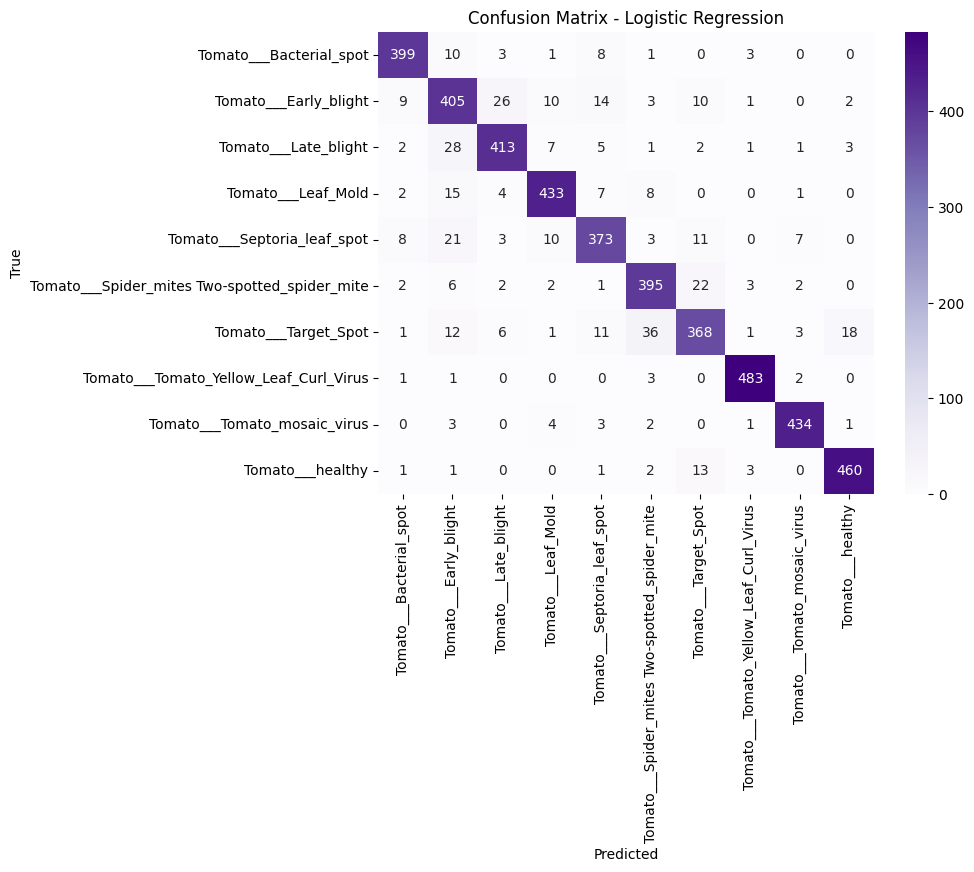

💾 Model saved as 'best_model_LR.pkl'


In [18]:
# 🌿 Step 9: Train Logistic Regression on MobileNet Features
# ==========================================================
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

print("🔹 Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=200, n_jobs=-1, verbose=1)
lr_model.fit(features_train, labels_train)

print("\n🔹 Evaluating...")
y_pred = lr_model.predict(features_val)
acc = accuracy_score(labels_val, y_pred)
print(f"\n✅ Validation Accuracy: {acc*100:.2f}%")

target_names = list(train_gen.class_indices.keys())
print("\n📊 Classification Report:")
print(classification_report(labels_val, y_pred, target_names=target_names))

cm = confusion_matrix(labels_val, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

joblib.dump(lr_model, 'best_model_LR.pkl')
print("💾 Model saved as 'best_model_LR.pkl'")
